# Exploratory Data Analysis

DC Police have created an interactive web app called [DC Crime Card](https://dcatlas.dcgis.dc.gov/crimecards/), which provides the capability to search for specific kinds of crimes and visual them as hotspots. Not all crime is related. There is a significant difference between jaywalking and littering to rape and murder. For this analysis, I narrowed my search for all violent gun-related crimes that occurred in 2017. A total of 1,574 incidents were reported.

## Loading and Cleaning

In [21]:
# importing the libraries
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [150]:
# joining the file
file = os.path.join('data/', 'crime', 'crime_full.csv')
crime_df = pd.read_csv(file)

In [189]:
# viewing and understanding the data types for each column
crime_df.head()
#crime_df.info()

,NEIGHBORHOOD_CLUSTER,CENSUS_TRACT,offensegroup,LONGITUDE,END_DATE,offense-text,SHIFT,YBLOCK,DISTRICT,WARD,...,CCN,OFFENSE,OCTO_RECORD_ID,ANC,REPORT_DAT,METHOD,location,LATITUDE,Month,Weekday
0,cluster 22,11001011100,violent,-76.974191,2017-11-13T11:35:34.000,robbery,day,139566,5,5,...,17196635,robbery,17196635-01,5C,2017-11-13T16:35:36.000Z,gun,"38.923973417948297,-76.974193510301745",38.923966,Nov,Monday
1,cluster 31,11001007809,violent,-76.927129,2017-11-17T22:57:16.000,assault w/dangerous weapon,evening,136994,6,7,...,17199382,assault w/dangerous weapon,17199382-01,7C,2017-11-18T03:57:39.000Z,gun,"38.900784092272893,-76.927131753204847",38.900776,Nov,Friday
2,cluster 22,11001009102,violent,-76.984881,2017-11-17T22:45:01.000,assault w/dangerous weapon,midnight,139563,5,5,...,17199489,assault w/dangerous weapon,17199489-01,5C,2017-11-18T07:01:11.000Z,gun,"38.923948264522402,-76.984883745500071",38.923940,Nov,Friday
3,cluster 17,11001001803,violent,-77.036383,2017-09-21T01:45:23.000,robbery,day,144379,4,4,...,17163823,robbery,17163823-01,4A,2017-09-21T13:58:32.000Z,gun,"38.967327474290151,-77.036385027160023",38.967320,Sep,Thursday
4,cluster 21,11001003400,violent,-77.015013,2017-10-25T00:27:59.000,robbery,midnight,138541,3,1,...,17185001,robbery,17185001-01,1B,2017-10-25T08:00:34.000Z,gun,"38.914741765118478,-77.015015097113633",38.914734,Oct,Wednesday


Let's convert the start date to datetime format so we can get a sense of the crime committed per month and week. The `crime_df['START_DATE']` column is formatted as Year, month, date, time. However, there is a `T` between date and time. I'll replace the `T` with a space and then format it correctly. I'll also remove the microseconds.

`crime_df['CENSUS_TRACT']` will be converted to an int type and padded with the correct GEO code so it can be paired with the GEOJSON file
- if 3 digits: add 11001000
- if 4 digits: add 1100100
- if 5 digits: add 110010

In [152]:
crime_df['START_DATE'] = crime_df['START_DATE'].str.replace('T', ' ').str.replace('.000', '')
crime_df['START_DATE'] = pd.to_datetime(crime_df['START_DATE'], format='%Y-%m-%d %H:%M:%S')

crime_df['CENSUS_TRACT'] = crime_df['CENSUS_TRACT'].fillna(0)
crime_df['CENSUS_TRACT'] = crime_df['CENSUS_TRACT'].astype(int) # converted to int so remove he .0 decimal 

crime_df['CENSUS_TRACT'] = crime_df['CENSUS_TRACT'].astype(str) # converted to str so i can pad the digits needed
#crime_df['CENSUS_TRACT'] = crime_df['CENSUS_TRACT'].str.rjust(11, '110010')
#len(crime_df['CENSUS_TRACT'][0])

new_list =[]
for i in crime_df['CENSUS_TRACT']:
    if len(i) == 3:
        i='11001000'+i
    if len(i) == 4:
        i='1100100'+i
    if len(i) == 5:
        i='110010'+i
    new_list.append(i)

#print(new_list)
crime_df['CENSUS_TRACT'] = new_list
#crime_df['CENSUS_TRACT'] = crime_df['CENSUS_TRACT'].astype(str)

In [213]:
# verify
crime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1574 entries, 0 to 1573
Data columns (total 32 columns):
NEIGHBORHOOD_CLUSTER    1559 non-null object
CENSUS_TRACT            1574 non-null object
offensegroup            1574 non-null object
LONGITUDE               1574 non-null float64
END_DATE                1424 non-null object
offense-text            1574 non-null object
SHIFT                   1574 non-null object
YBLOCK                  1574 non-null int64
DISTRICT                1574 non-null int64
WARD                    1574 non-null int64
YEAR                    1574 non-null int64
offensekey              1574 non-null object
BID                     89 non-null object
sector                  1574 non-null object
PSA                     1574 non-null int64
ucr-rank                1574 non-null int64
BLOCK_GROUP             1561 non-null object
VOTING_PRECINCT         1574 non-null object
XBLOCK                  1574 non-null int64
BLOCK                   1574 non-null object
S

I'll create a new `Month` and `Weekday` column to analyze when crimes occur.

In [154]:
import calendar

crime_df['Month'] = (crime_df['START_DATE'].dt.month).apply(lambda x: calendar.month_abbr[x])
crime_df['Month'] = pd.Categorical(crime_df['Month'], categories=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 
                                                                  'Sep', 'Oct', 'Nov', 'Dec'], ordered=True)

crime_df['Weekday'] = crime_df['START_DATE'].dt.weekday_name
crime_df['Weekday'] = pd.Categorical(crime_df['Weekday'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
                                                                      'Friday', 'Saturday', 'Sunday'], ordered=True)

Now that I have `Month` and `Weekday` columns, I can start the exploring.

## Let's explore the data

### Number of crimes reported each month

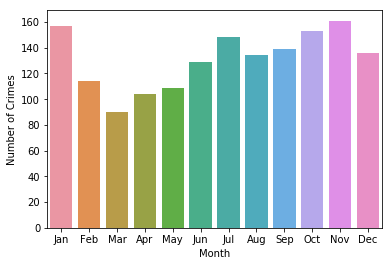

In [155]:
sns.countplot(x='Month', data=crime_df)
plt.ylabel('Number of Crimes')
plt.show()

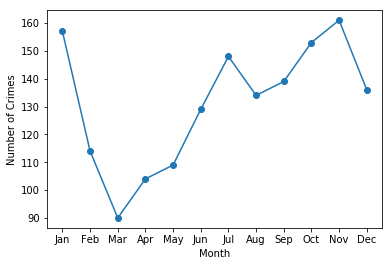

In [156]:
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
crime_df.groupby('Month')['CENSUS_TRACT'].count().plot(marker='o')
plt.xticks(np.arange(12), month)
plt.ylabel('Number of Crimes')
plt.show()

Crime seems to decrease during the winter months with the lowest point in March. Around May, it starts to increase with a peack in November.

### Number of crimes reported each weekday

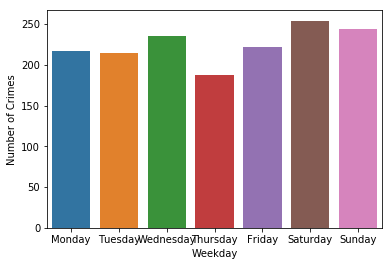

In [157]:
sns.countplot(x='Weekday', data=crime_df)
plt.ylabel('Number of Crimes')
plt.show()

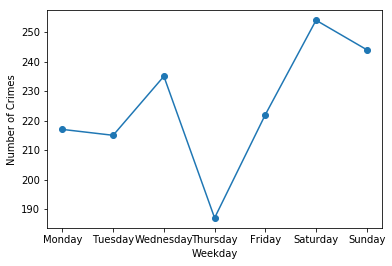

In [158]:
weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
crime_df.groupby('Weekday')['CENSUS_TRACT'].count().plot(marker='o')
plt.xticks(np.arange(7), weekday)
plt.ylabel('Number of Crimes')
plt.show()

Thursday's see the lowest crime incidents while the weekend (with a peak on Saturday) see the highest.

### Time of day violent crimes occur

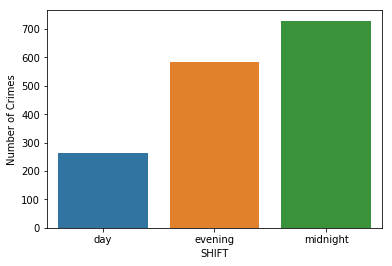

In [191]:
sns.countplot(x='SHIFT', data=crime_df)
plt.ylabel('Number of Crimes')
plt.show()

Violent crimes tend to occur in the evening to midnight time (passed 5pm)

### Now I'll analyze where violent crimes occur

In [159]:
#crime_df['CENSUS_TRACT'].value_counts()
crime_df['CENSUS_TRACT'].nunique()

166

In [195]:
location = crime_df['CENSUS_TRACT'].value_counts()
#type(location)

#location = crime_df.groupby('CENSUS_TRACT').count().sort_values(ascending=False)
location = location[:30] # only want the top 25
#location

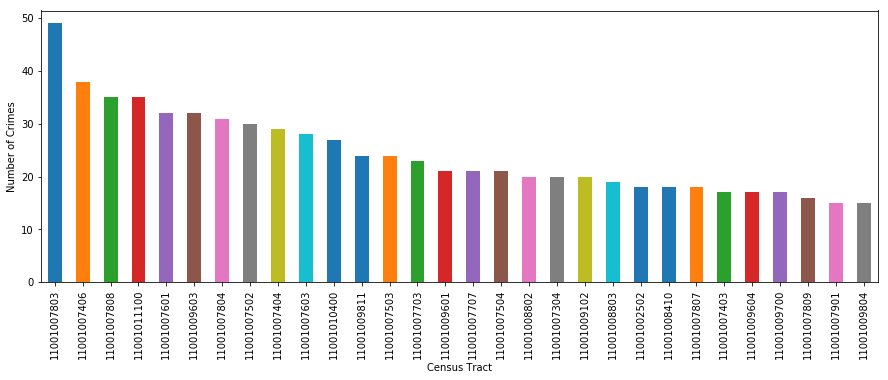

In [196]:
location.plot(kind='bar', figsize=(15,5))
plt.xlabel('Census Tract')
plt.ylabel('Number of Crimes')
plt.show()

The census tracts provide a granular area of DC (there over 170 tracts). This is great when trying to narrow pockets of crime. However, the DC government divides DC into 8 separate areas called Wards. Let’s analyze crime based on Wards. 

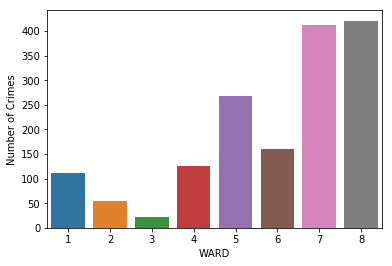

In [168]:
sns.countplot(x='WARD', data=crime_df)
plt.ylabel('Number of Crimes')
plt.show()

Most of the violent crimes are committed in DC are in Wards 7 and 8.

### Analyzing the shift of day for each Ward

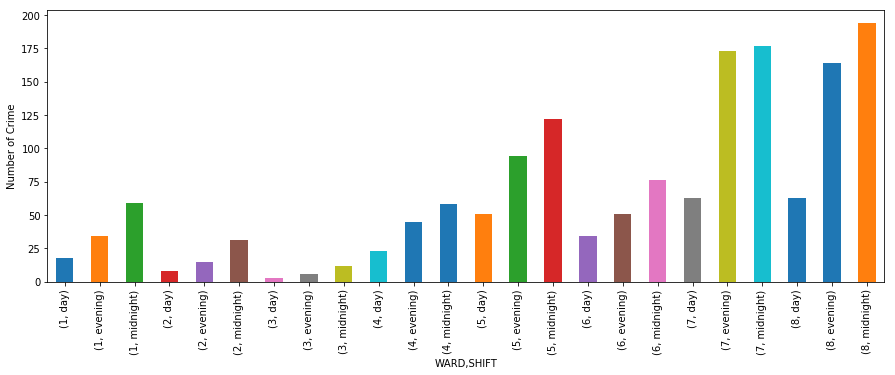

In [185]:
crime_df.groupby(['WARD', 'SHIFT'])['CENSUS_TRACT'].count().plot(kind='bar', figsize=(15,5))
plt.ylabel('Number of Crime')
plt.show()

Even though most violent crimes occurs in Ward 7 and 8, most of the crimes occur during the evening and midnight.

The goal is to try to build a model that can predict if a violent crime will occur based on census tract characteristics. I will count the number of crimes occurred for each census and merge it with the dc_data_2017.csv file.

In [239]:
location = crime_df['CENSUS_TRACT'].value_counts()
#crime_df['Count'] = location
type(location)
#location

pandas.core.series.Series

In [294]:
temp = pd.DataFrame()
temp['Crime_count'] = location
temp['GEOID2'] = temp.index
temp.reset_index(inplace=True)
temp.rename(columns={'index': 'GEOID2'}, inplace=True)
temp['GEOID2'] = temp['GEOID2'].astype('int64')
#temp.info()
temp.head()

,GEOID2,Crime_count
0,11001007803,49
1,11001007406,38
2,11001007808,35
3,11001011100,35
4,11001007601,32


In [300]:
# reading the DC census tract dataframe 
dc_df = pd.read_csv('dc_data_2017.csv')
dc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 13 columns):
OBJECTID              179 non-null int64
TRACT                 179 non-null int64
GEO                   179 non-null object
GEOID2                179 non-null int64
GEO_display_label     179 non-null object
Population            179 non-null int64
Income                177 non-null float64
Home_value            172 non-null float64
No_car_percent        175 non-null float64
Bachelor_or_higher    178 non-null float64
Employment_percent    178 non-null float64
Marital_percent       178 non-null float64
Veterans_percent      177 non-null float64
dtypes: float64(7), int64(4), object(2)
memory usage: 18.3+ KB


In [312]:
merge_df = dc_df.merge(temp, on='GEOID2', how='left')
merge_df.head()

,OBJECTID,TRACT,GEO,GEOID2,GEO_display_label,Population,Income,Home_value,No_car_percent,Bachelor_or_higher,Employment_percent,Marital_percent,Veterans_percent,Crime_count
0,11,100,1400000US11001000100,11001000100,"Census Tract 1, District of Columbia, District...",5170,168477.0,1048200.0,0.181,0.9129,0.754,0.489,0.082,1.0
1,12,201,1400000US11001000201,11001000201,"Census Tract 2.01, District of Columbia, Distr...",3682,NaN,NaN,NaN,1.0000,0.393,0.010,NaN,NaN
2,13,202,1400000US11001000202,11001000202,"Census Tract 2.02, District of Columbia, Distr...",4473,162981.0,1195300.0,0.168,0.9264,0.641,0.305,0.035,4.0
3,14,300,1400000US11001000300,11001000300,"Census Tract 3, District of Columbia, District...",6374,133008.0,893000.0,0.160,0.8909,0.794,0.313,0.021,2.0
4,15,400,1400000US11001000400,11001000400,"Census Tract 4, District of Columbia, District...",1489,143229.0,1223700.0,0.120,0.7906,0.617,0.497,0.044,NaN


In [313]:
# save the new merged dataframe to it can be modeled
merge_df.to_csv('dc_data_to_model.csv')